This example conducts an analysis of the initial optwrf database in an attempt to tease out relationships among the different parameters.

Last Updated by Jeffrey Sward on June 15, 2020.

In [1]:
import csv
import datetime
import math
import random
import sys
import time

import shap
import seaborn as sns
import pandas as pd
#import prince
import numpy as np
import sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from optwrf.wrfparams import num2name
from optwrf.helper_functions import date2season
import xarray as xr

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
# Read in the optwrf csv data file 
dateparse = lambda x: pd.datetime.strptime(x, '%b %d %Y')
data = pd.read_csv('./optwrf_database_090820.csv', parse_dates=['start_date'], date_parser=dateparse)
# Replace missing data with NaN values
data['fitness'].values[data['fitness'] > 6 * 10 ** 23] = np.nan
# Determine the season
data['season'] = [date2season(dat) for dat in data.start_date]
data.iloc[:5,:]


The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


,start_date,mp_physics,ra_lw_physics,ra_sw_physics,sf_surface_physics,bl_pbl_physics,cu_physics,sf_sfclay_physics,fitness,ghi_error,wpd_error,runtime,season
0,2011-11-10,2,5,99,2,4,16,4,31298.680307,10831.90,56780220.0,03h 23m 16s,fall
1,2011-11-25,51,1,7,1,11,1,1,31516.466190,21342.01,41989356.0,00h 51m 09s,fall
2,2011-10-07,13,3,3,7,12,10,1,19734.008641,8762.55,30784876.0,01h 05m 24s,fall
3,2011-08-13,17,3,2,4,12,16,1,24613.299895,20582.19,13254863.0,01h 51m 31s,summer
4,2011-04-02,3,31,7,7,2,6,2,71681.216361,52733.16,64502156.0,00h 46m 48s,spring


## Random Forest Model

In this section, I train a random forest regression model to compare the relative feature importances. 

In [3]:
# Drop the start_date variable to train the random forest regressor
RFfeatures = data[['mp_physics', 'ra_lw_physics', 'ra_sw_physics', 
                  'sf_surface_physics', 'bl_pbl_physics', 'cu_physics', 
                  'fitness']]

# Drop rows where there are NaN values
RFfeatures = RFfeatures.dropna()

# Convert param_ids back to names so the RF algorithm will recognize them as separe categories
RFfeatures['mp_physics'] = num2name(RFfeatures.mp_physics, 'microphysics')
RFfeatures['ra_lw_physics'] = num2name(RFfeatures.ra_lw_physics, 'lw radiation')
RFfeatures['ra_sw_physics'] = num2name(RFfeatures.ra_sw_physics, 'sw radiation')
RFfeatures['sf_surface_physics'] = num2name(RFfeatures.sf_surface_physics, 'land surface')
RFfeatures['bl_pbl_physics'] = num2name(RFfeatures.bl_pbl_physics, 'PBL')
RFfeatures['cu_physics'] = num2name(RFfeatures.cu_physics, 'cumulus')
RFfeatures

,mp_physics,ra_lw_physics,ra_sw_physics,sf_surface_physics,bl_pbl_physics,cu_physics,fitness
0,lin,new goddard,gfdl,noah,qnse,new tiedtke,31298.680307
1,p3 2mom,rrtm,flg,5 layer,shin-hong,kain-fritsch,31516.466190
2,sbu-ylin,cam,cam,pleim-xiu,gbm,mod kain-fritsch,19734.008641
3,nssl 2mom,cam,goddard,noah-mp,gbm,new tiedtke,24613.299895
4,wsm3,held-suarez,flg,pleim-xiu,myj,tiedtke,71681.216361
...,...,...,...,...,...,...,...
561,lin,gfdl,rrtmg,5 layer,boulac,hwrf gfs sas,16485.684294
562,sbu-ylin,cam,rrtmg,clm4,gbm,old kain-fritsch,30626.986899
563,lin,rrtm,rrtmg,5 layer,boulac,hwrf gfs sas,31549.822046
564,sbu-ylin,rrtm,rrtmg,clm4,gbm,old kain-fritsch,25612.132870


In [4]:
# One-hot encode the data using pandas get_dummies
RFfeatures = pd.get_dummies(RFfeatures)
RFfeatures.iloc[:5,:]

,fitness,mp_physics_cam5.1,mp_physics_goddard,mp_physics_kressler,mp_physics_lin,mp_physics_milbrandt2mom,mp_physics_morrison2mom,mp_physics_nssl 1mom,mp_physics_nssl 1mom lfo,mp_physics_nssl 2mom,...,cu_physics_grell3d,cu_physics_hwrf gfs sas,cu_physics_kain-fritsch,cu_physics_mod kain-fritsch,cu_physics_multi kain-fritsch,cu_physics_new tiedtke,cu_physics_old kain-fritsch,cu_physics_tiedtke,cu_physics_ysu gfs sas,cu_physics_zhang-mcfarlane
0,31298.680307,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,31516.466190,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,19734.008641,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,24613.299895,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
4,71681.216361,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [5]:
# Labels are the values we want to predict
labels = RFfeatures['fitness']

# Remove the labels from the features
RFfeatures = RFfeatures.drop(['fitness'], axis = 1)
feature_names = list(RFfeatures.columns)

# Train the Random Forest Regressor model
model = RandomForestRegressor()
model.fit(RFfeatures, labels)
# print(model.feature_importances_)

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

# SHAP TreeExplainer

SHAP values represent a feature's contribution to a change in the model ouput. In contrast to the feature importances shown above which give a relative importance and are therefore comparative, SHAP values reveal if each feature pushes model output higher or lower, so therefore can be summed -- revealing the contribution that a group of features have on model output as well. 

In [6]:
# load JS visualization code to notebook
shap.initjs()

In [7]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
try:
    shap_values = explainer.shap_values(RFfeatures)
except:
    shap_values = explainer.shap_values(RFfeatures, check_additivity=False)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


# Summary Plots
## SHAP Summary Plot

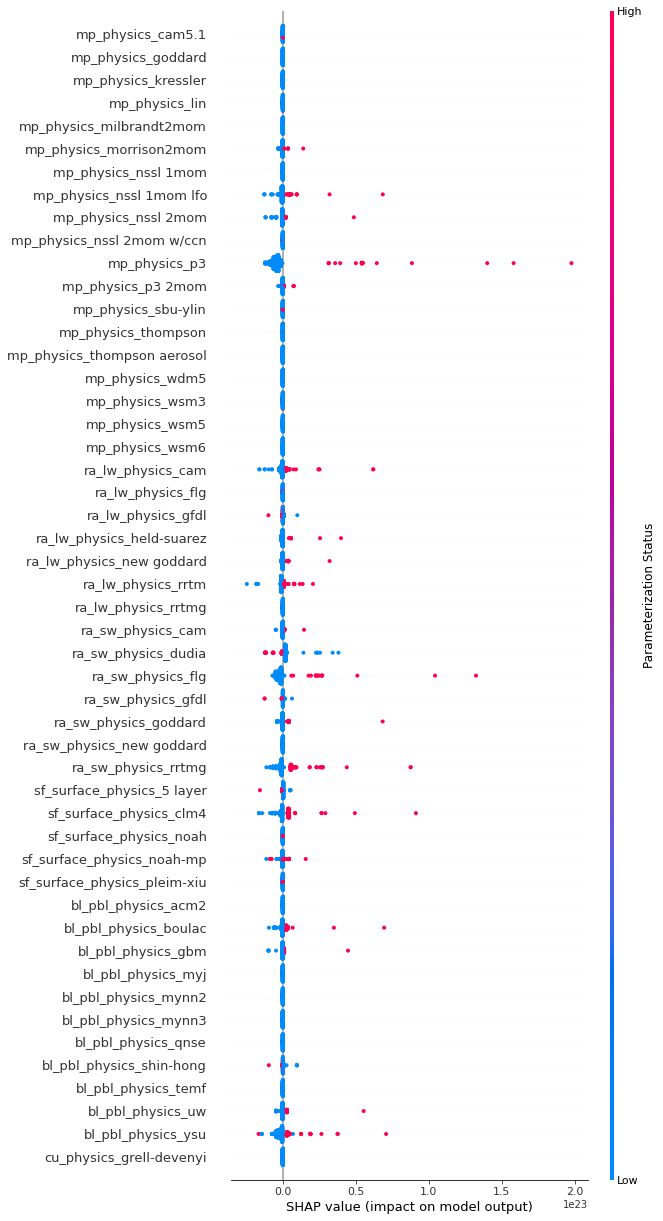

In [8]:
# summarize the effects of all the features
# NOTE: there are only two options for each feature value (1: physics scheme used; 0: physics schemem not used)
# meaning that all red dots correspond to a package being used whereas blue dots correspond to a package NOT being 
# used. Therefore, this plot can be interpreted as: red values on the left are those that push model fitness (error)
# lower, and red values on the right increase model error. The further to the right the dots fall, 
# the higher the error the use of this physics package causes. 
fig = plt.figure()
shap.summary_plot(shap_values, RFfeatures, max_display=50, color_bar_label='Parameterization Status', sort=False)
fig_path = f'/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/Shap_summary.pdf'
# fig.savefig(fig_path, transparent=True, bbox_inches='tight')

## Custom Summary Plot

In [23]:
# Create a pandas DataFrame to organize the shapley values -- this requires a multiindex 
# as I care about keeping track of unique models and different physics schemes.
# shap_data = xr.DataArray(shap_values, dims=("wrf_physics", "scheme"), coords={"scheme": feature_names})
shap_data = pd.DataFrame(shap_values, columns=feature_names)
shap_data

,mp_physics_cam5.1,mp_physics_goddard,mp_physics_kressler,mp_physics_lin,mp_physics_milbrandt2mom,mp_physics_morrison2mom,mp_physics_nssl 1mom,mp_physics_nssl 1mom lfo,mp_physics_nssl 2mom,mp_physics_nssl 2mom w/ccn,...,cu_physics_grell3d,cu_physics_hwrf gfs sas,cu_physics_kain-fritsch,cu_physics_mod kain-fritsch,cu_physics_multi kain-fritsch,cu_physics_new tiedtke,cu_physics_old kain-fritsch,cu_physics_tiedtke,cu_physics_ysu gfs sas,cu_physics_zhang-mcfarlane
0,350.051958,-1.845743,-83.265653,776.293448,-33.260988,-1.333934e+20,-282.799986,-3.900068e+20,-4.657655e+21,-57.034553,...,3.613457e+19,7.395202,-6.149966e+20,43.437082,-2.480303e+20,169.074281,104.760524,-6.979820e+20,-3.552734,6.905737
1,7.264131,3.015581,-7.871802,-12.826967,3.940831,-2.988673e+21,-48.101940,-2.740838e+21,-7.665659e+21,0.339396,...,3.766296e+20,19.358442,4.707792e+21,22.714211,-2.124876e+20,-4.044082,227.198802,-5.684489e+20,-12.295585,5.434627
2,14.104472,-5.014151,-8.830280,15.144029,4.708410,-1.333934e+20,-69.742268,-5.119984e+20,-4.677764e+20,-17.445084,...,3.613457e+19,-100.929360,-7.992713e+20,-23.737401,-2.782980e+21,8.149481,-62.908859,-1.725405e+21,-0.900732,7.060887
3,12.861364,-4.922386,-6.833667,5.085181,6.368127,-7.445214e+19,-69.393854,-4.159813e+20,1.882825e+21,-5.425911,...,3.613457e+19,-14.415619,-8.780988e+20,-215.969201,-2.782980e+21,111.336292,11.069376,-1.708418e+21,-2.273901,10.860678
4,-16.491613,4.754126,-6.645714,2.829267,2.700741,-2.988673e+21,-22.970438,-3.763866e+21,-7.665659e+21,15.169758,...,3.766296e+20,17.776378,-5.434698e+20,9.212632,-1.589756e+20,-1.744984,-214.787327,4.941422e+22,-4.826785,3.856971
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362,-18.505993,-5.014151,-7.487563,73.729688,3.883757,-1.333934e+20,-70.855346,-3.956903e+20,-4.677764e+20,-4.091645,...,3.613457e+19,37.035743,-6.444739e+20,15.830688,-8.834712e+20,-4.143534,42.418790,-1.070076e+21,8.852916,5.185408
363,-1.138903,-5.101155,-7.486636,126.521754,5.586323,-1.333934e+20,-63.001946,-3.469801e+20,-3.974605e+20,-0.838762,...,2.031349e+20,-78.715907,-6.303373e+20,-0.589108,-8.157995e+21,-2.135594,575.651352,-2.069219e+21,-0.214524,1.009153
364,-8.341394,-5.014151,-8.197921,187.179955,4.575914,-1.333934e+20,-77.561213,-3.956903e+20,-4.677764e+20,5.258853,...,3.613457e+19,45.266781,-7.288161e+20,13.349714,-8.834712e+20,-8.221958,471.663107,-1.063446e+21,-0.631174,9.028668
365,-11.731021,-5.101155,-7.463866,7.778049,5.586323,-1.333934e+20,-75.290937,-3.956903e+20,-3.974605e+20,-26.288289,...,2.031349e+20,-76.242062,-7.230631e+20,-4.665154,-8.834712e+20,0.466780,318.923200,-2.092903e+21,-0.786380,0.818574


In [29]:
# Format the data into a more convenient pandas DataFrame
midx = pd.MultiIndex.from_product([shap_data.index, shap_data.columns], names=('model_num', 'scheme_name'))
optwrf_data = pd.DataFrame(shap_data.stack(), index=midx, columns=['shap_values'])
RFfeatures = RFfeatures.reset_index()
RFfeatures = RFfeatures.drop(['index'], axis = 1)
df = pd.DataFrame(RFfeatures.stack(), index=midx, columns=['scheme_status'])
optwrf_data = optwrf_data.join(df, ['model_num', 'scheme_name'])
optwrf_data = optwrf_data.reset_index()
optwrf_data['scheme_name_short'] = optwrf_data.scheme_name.str.split('_').str[-1]
optwrf_data

,model_num,scheme_name,shap_values,scheme_status
0,0,mp_physics_cam5.1,3.500520e+02,0
1,0,mp_physics_goddard,-1.845743e+00,0
2,0,mp_physics_kressler,-8.326565e+01,0
3,0,mp_physics_lin,7.762934e+02,1
4,0,mp_physics_milbrandt2mom,-3.326099e+01,0
...,...,...,...,...
22382,366,cu_physics_new tiedtke,-1.270473e+00,0
22383,366,cu_physics_old kain-fritsch,-2.105045e+02,0
22384,366,cu_physics_tiedtke,-6.613208e+20,0
22385,366,cu_physics_ysu gfs sas,-4.080470e+00,0


In [54]:
for entry in optwrf_data.scheme_status.iloc[:5]:
    if entry == 1:
        print('On')
    else:
        print('Off')

off
off
off
on
off


In [66]:
# [1 if x > 0 else 0 for x in l]
optwrf_data['scheme_status'] = ['On' if status == 1 else 'Off' for status in optwrf_data.scheme_status]

In [67]:
# Isolate the physics being parameterized
physics = optwrf_data.scheme_name.str.split('_').str[0]
# Subset the optwrf data by physics parameterization
mp_shap = optwrf_data[physics == 'mp']
ra_shap = optwrf_data[physics == 'ra']
sf_shap = optwrf_data[physics == 'sf']
bl_shap = optwrf_data[physics == 'bl']
cu_shap = optwrf_data[physics == 'cu']

In [68]:
ra_shap

,model_num,scheme_name,shap_values,scheme_status,scheme_name_short
19,0,ra_lw_physics_cam,-2.976859e+20,Off,cam
20,0,ra_lw_physics_flg,-1.743755e+01,Off,flg
21,0,ra_lw_physics_gfdl,3.849535e+19,Off,gfdl
22,0,ra_lw_physics_held-suarez,-1.234794e+20,Off,held-suarez
23,0,ra_lw_physics_new goddard,3.810507e+21,On,new goddard
...,...,...,...,...,...
22354,366,ra_sw_physics_flg,-3.066300e+21,Off,flg
22355,366,ra_sw_physics_gfdl,2.160626e+20,Off,gfdl
22356,366,ra_sw_physics_goddard,-2.042278e+20,Off,goddard
22357,366,ra_sw_physics_new goddard,-1.312259e+02,Off,new goddard


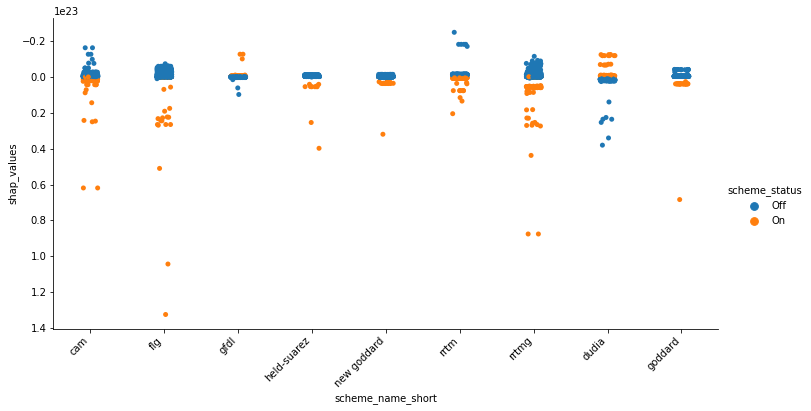

In [69]:
# Draw a seaborn catplot for one of the physics categories
catplt = sns.catplot(x='scheme_name_short', y='shap_values', data=ra_shap, hue='scheme_status',
                     height=5, aspect=2)
# Format the axes
for ax in catplt.axes.flat:
    # Invert the shapley values for semantic resonance
    ax.invert_yaxis()
    # Rotate the axis labels so they don't overlap with one another
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_horizontalalignment('right')

In [192]:
def physics_shap_catplot(catplot_data, xdata='shap_values', ydata='scheme_name_short', 
                         plot_type='strip', split=False, ylabels=None, save_fig=False, fig_name=None):
    """
    Draws a seaborn catplot for one of the physics categories (MP, RA, BL, SF, CU)
    """
    sns.set_context('paper')
    sns.set_theme(style='ticks')
    catplt = sns.catplot(x=xdata, y=ydata, data=catplot_data, hue='scheme_status', 
                kind=plot_type, split=split, height=8.27, aspect=11.7/8.27, legend_out=False)
    # Tweak the visual presentation...
    plt.axvline(0, 0, 1, c='black', lw=1, ls='-')
    catplt._legend.set_title("Scheme Status")
    catplt.despine(top=False, right=False)
    # Format the axes
    for ax in catplt.axes.flat:
        for label in ax.get_xticklabels():
            label.set_fontsize(14)
        for label in ax.get_yticklabels():
            label.set_fontsize(14)
    #     ax.xaxis.grid(True)
        ax.set_xlabel("Influence on Model Error (SHAP Values)\n ← Lower Error       Hihger Error  →", fontsize=16)
        if ylabels is not None:
            ax.set_yticklabels(ylabels)
        ax.set_ylabel("")
        ax.set(xlim=(-catplot_data.shap_values.max(), catplot_data.shap_values.max()))
    # Save the figure
    if save_fig is True:
        if fig_name is not None:
            catplt.savefig(fig_name, dpi=300)
        else:
            catplt.savefig('physics_shap_catplot.png', dpi=300)

The `split` parameter has been renamed to `dodge`.


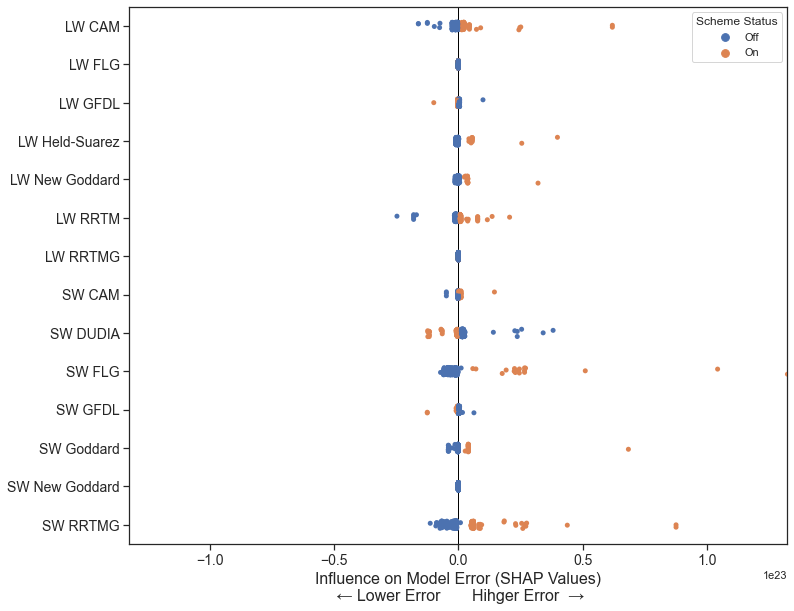

In [190]:
ylabs = ['LW CAM', 'LW FLG', 'LW GFDL', 'LW Held-Suarez', 'LW New Goddard', 'LW RRTM', 'LW RRTMG', 
         'SW CAM', 'SW DUDIA', 'SW FLG', 'SW GFDL', 'SW Goddard', 'SW New Goddard', 'SW RRTMG']
physics_shap_catplot(ra_shap, xdata='shap_values', ydata='scheme_name', 
                     plot_type='strip', ylabels=ylabs)

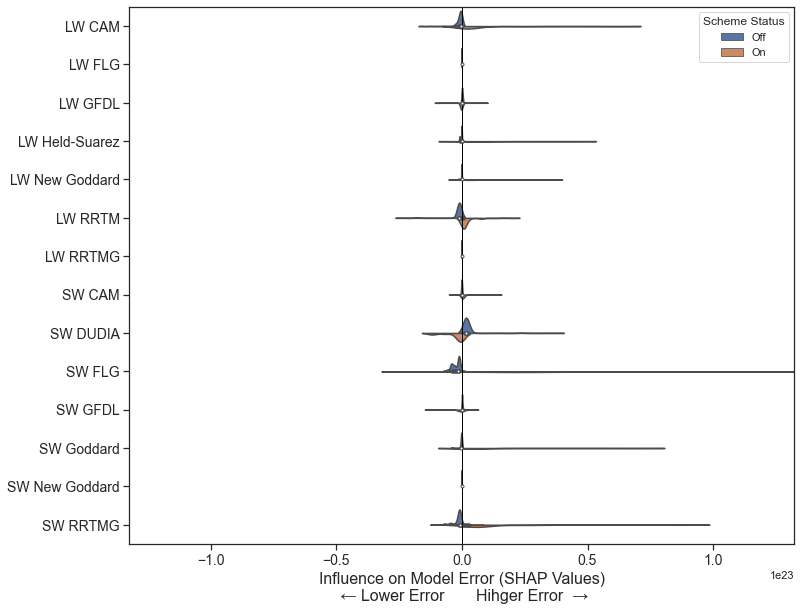

In [191]:
physics_shap_catplot(ra_shap, xdata='shap_values', ydata='scheme_name', 
                     plot_type='violin', split=True, ylabels=ylabs)

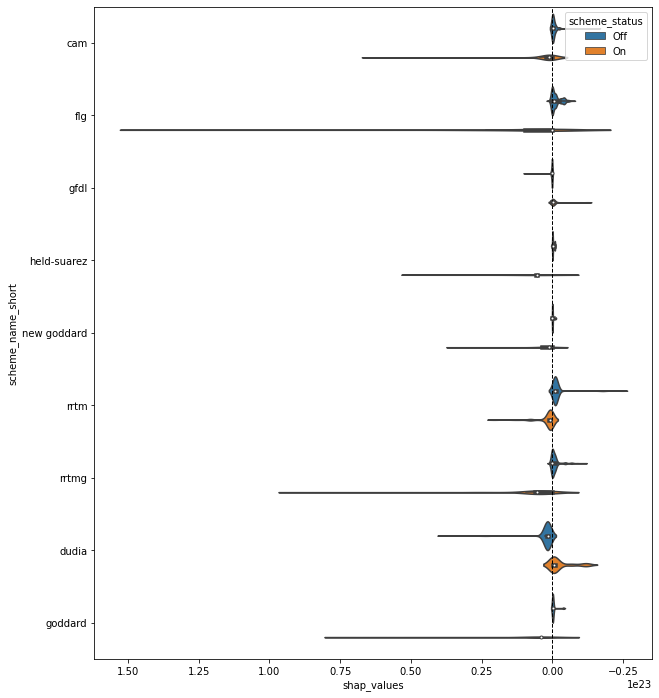

In [117]:
# Draw a nested violinplot and split the violins for easier comparison
fig, ax = plt.subplots(figsize=(10, 12))
violin = sns.violinplot(y='scheme_name_short', x='shap_values', data=ra_shap, 
                        hue='scheme_status', height=10, aspect=1.2)
violin.invert_xaxis()
plt.axvline(0, 0, 1, c='black', lw=1, ls='--')
# violin.set_xticklabels(violin.get_xticklabels(), rotation=45, horizontalalignment='right')

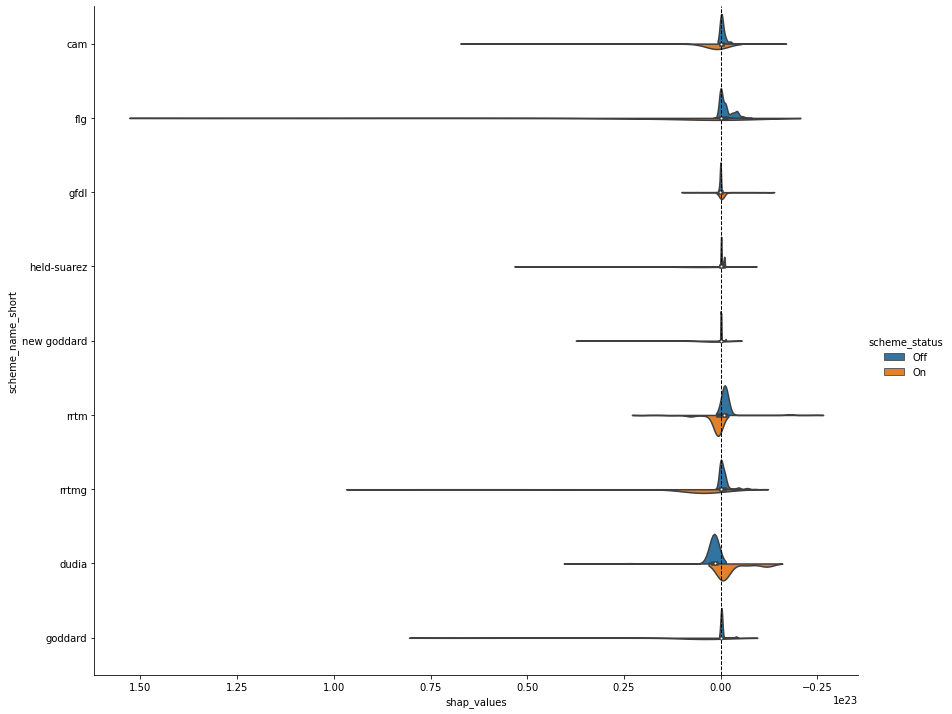

In [121]:
violin2 = sns.catplot(y='scheme_name_short', x='shap_values', data=ra_shap, hue='scheme_status', 
                      kind="violin", split=True, height=10, aspect=1.2)
# Format the axes
for ax in violin2.axes.flat:
    # Invert the shapley values for semantic resonance
    ax.invert_xaxis()
#     ax.set_xscale("log")
# Add a vertical line to show where the zero line is
plt.axvline(0, 0, 1, c='black', lw=1, ls='--')

In [ ]:
swarm = sns.catplot(x='scheme_name_short', y='shap_values', data=ra_shap, hue='scheme_status',
                    kind="swarm", height=5, aspect=2)
# Customize the axis
for ax in swarm.axes.flat:
    # Invert the shapley values for semantic resonance
    ax.invert_yaxis()
    # Rotate the axis labels so they don't overlap with one another
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_horizontalalignment('right')